In [1]:
import os
import pickle
import math

from dotenv import load_dotenv
from IPython.display import Image
from domain.vehicle import Vehicle
from abi.libs.rust_solver_lib import GAParameters
from abi.libs.rust_solver_lib import GraspParameters
from abi.libs.rust_solver_lib import RustSolverLib
from data.stops import stops
from distancesAPI import MapsAPI

%reload_ext autoreload
%autoreload 2

load_dotenv(override=True)

True

In [2]:
refetch_distances = False
calculate_time = False
plot_markers = False

In [3]:
addresses = [x.address for x in stops]
mapsAPI = MapsAPI(os.getenv('API_KEY'))
address_chunks = MapsAPI.split_in_chunks(addresses, 25)
distances = mapsAPI.split_distance_request(address_chunks, calculateTime = calculate_time) if refetch_distances else MapsAPI.get_from_cache()
distances = MapsAPI.convert_to_symmetric(distances)

In [4]:
with open('cache/distance_matrix', 'rb') as f:
    best_ever = pickle.load(f)

In [5]:
def insert_ids_in_distances(distances):
    return [[src_id, dest_id, distance] for src_id, sublist in enumerate(distances) for dest_id, distance in enumerate(sublist)]


In [39]:
number_of_routes = 4
distances_with_ids = insert_ids_in_distances(distances)
vehicles = [Vehicle(0, 1000), Vehicle(1, 1000), Vehicle(2, 1000), Vehicle(3, 1000)]

ga_parameters = GAParameters(
    population_size=200,
    elite_size=5,
    mutation_rate=0.05,
    local_search_rate=0.2,
    max_crossover_tries=100,
    max_generations=1000,
)

grasp_parameters = GraspParameters(
    rcl_size=math.floor(0.3 * len(stops)), max_improvement_times=10
)

relative_lib_path = f"../{os.getenv('RUST_SOLVER_LIB')}"
rust_lib = RustSolverLib(os.path.abspath(relative_lib_path))

rust_result = rust_lib.run_grasp_genetic_solver(
    vehicles[:number_of_routes], stops, distances_with_ids, grasp_parameters, ga_parameters
)

rust_addresses = [[stop.address for stop in route.stops] for route in rust_result]
total_distance = sum(x.total_distance for x in rust_result)

print(f"Total distance: {total_distance}")
print(f"Average distance: {total_distance / number_of_routes}\n")

print("Distance per vehicle:")
for route in rust_result:
    print(f"id: {route.vehicle.id}" + "\t" + f"Total distance: {route.total_distance}")
print()

print("Stops per vehicle:")
print(*[[stop.id for stop in route.stops] for route in rust_result], sep="\n")

Total distance: 38101.0
Average distance: 9525.25

Distance per vehicle:
id: 0	Total distance: 13572.0
id: 1	Total distance: 6072.0
id: 2	Total distance: 8424.0
id: 3	Total distance: 10033.0

Stops per vehicle:
[0, 13, 18, 21, 10, 9, 8, 7, 5, 6, 4, 3, 0]
[0, 14, 20, 16, 19, 17, 22, 23, 24, 0]
[0, 25, 15, 30, 29, 28, 31, 12, 0]
[0, 27, 26, 32, 2, 1, 11, 0]


In [18]:
[x.total_distance for x in rust_result]

[6629.0, 9640.0, 9488.0, 13123.0]

In [29]:
best_n2 = [
    [0, 14, 3, 4, 6, 5, 7, 10, 20, 21, 16, 31, 28, 29, 30, 32, 0],
    [0, 13, 15, 25, 26, 24, 22, 23, 18, 17, 19, 27, 9, 8, 12, 11, 1, 2, 0],
]

In [30]:
best_n3 = [
    [0, 13, 18, 23, 24, 26, 25, 1, 0],
    [0, 31, 28, 29, 30, 32, 19, 27, 9, 8, 6, 3, 4, 5, 7, 10, 21, 20, 16, 0],
    [0, 2, 11, 12, 15, 22, 17, 14, 0],
]

In [31]:
best_n4 = [
    [0, 13, 18, 21, 10, 9, 8, 7, 5, 6, 4, 3, 0],
    [0, 14, 20, 16, 19, 17, 22, 23, 24, 0],
    [0, 25, 15, 30, 29, 28, 31, 12, 0],
    [0, 27, 26, 32, 2, 1, 11, 0],
]

In [9]:
def recover_addresses(solution: list[list[int]]):
    return [[stops[stop_id].address for stop_id in route] for route in solution]

In [10]:
# with open('cache/best_ever', 'wb'):
#     pickle.dumps(best)

In [41]:
route_addresses = rust_addresses
imageCount = 1
for route in route_addresses:
    directions = mapsAPI.directions(route[0], route[0], route[1: 25])
    mapsAPI.save_to_image(directions, f"n{number_of_routes}_route_{imageCount}")
    imageCount += 1

In [42]:
if plot_markers:
    plot = mapsAPI.plot_markers(addresses)
    with open('test.jpg', 'wb') as f:
        for chunk in plot:
            f.write(chunk)

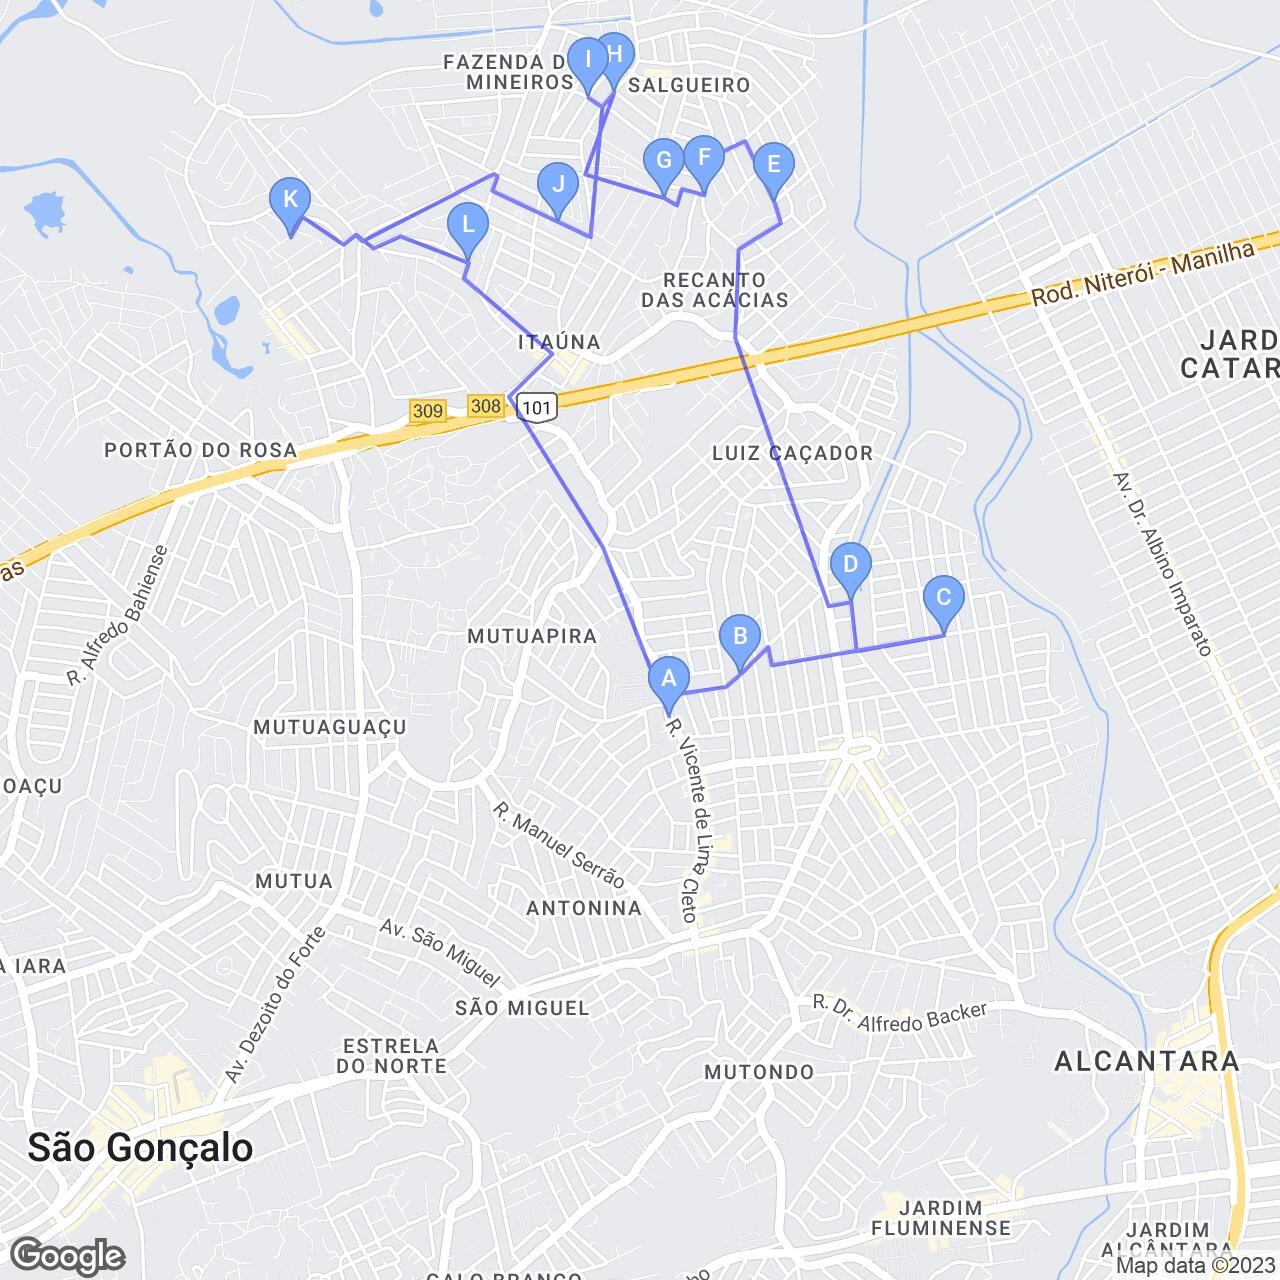

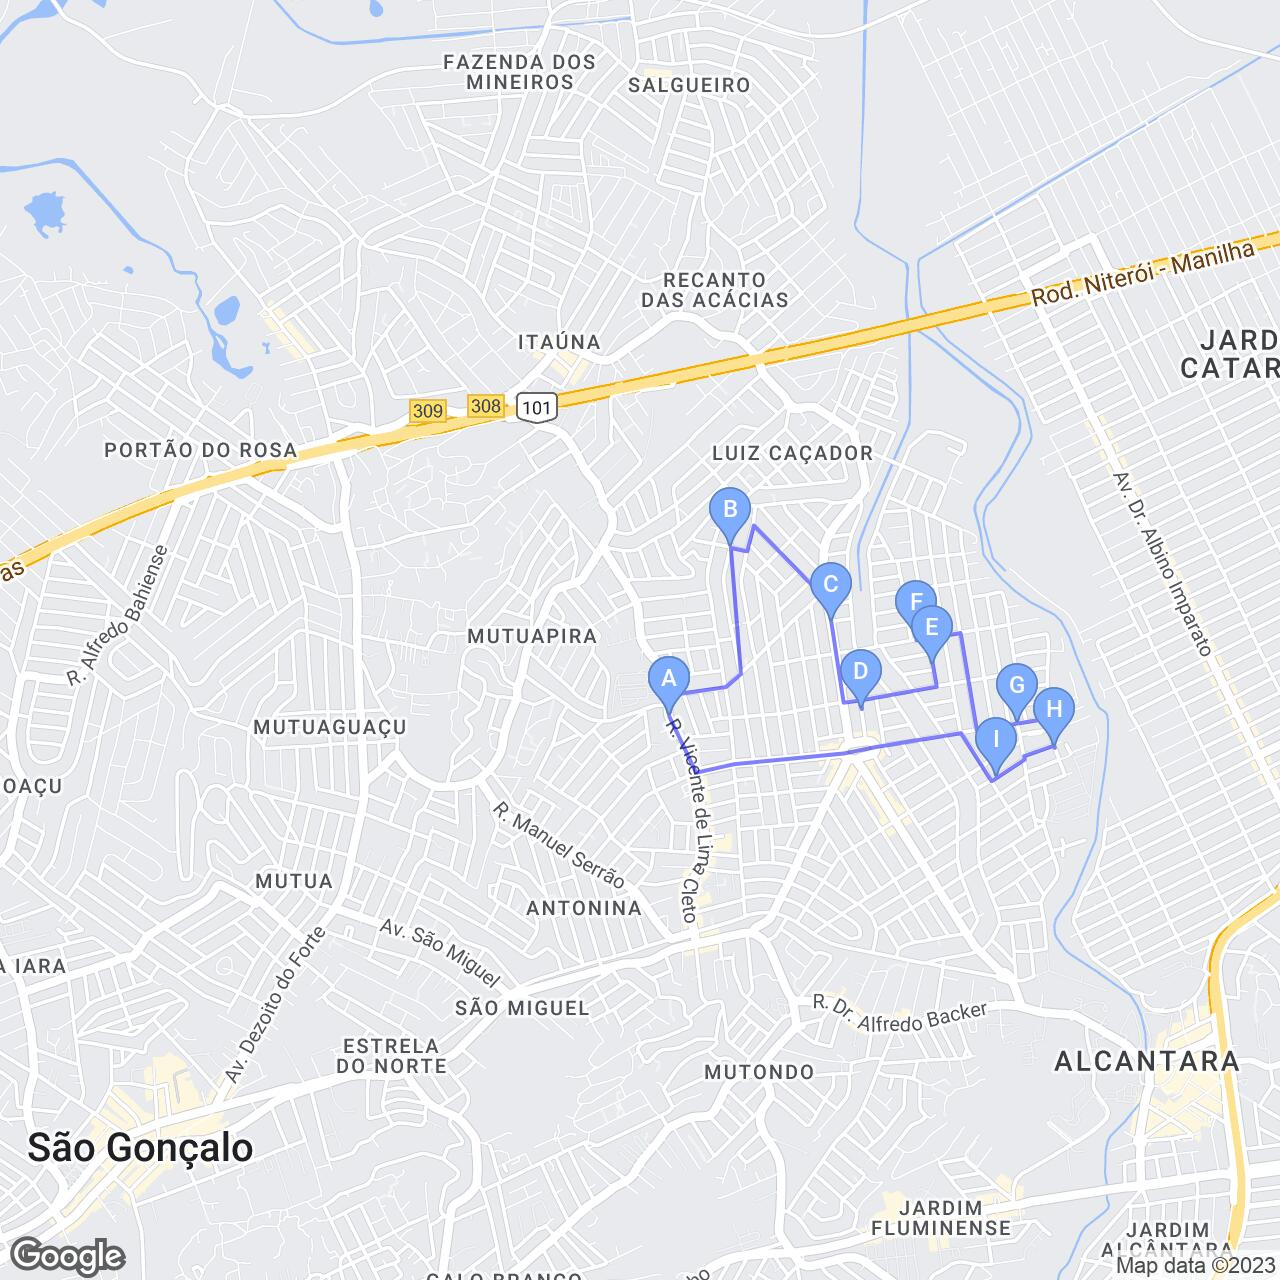

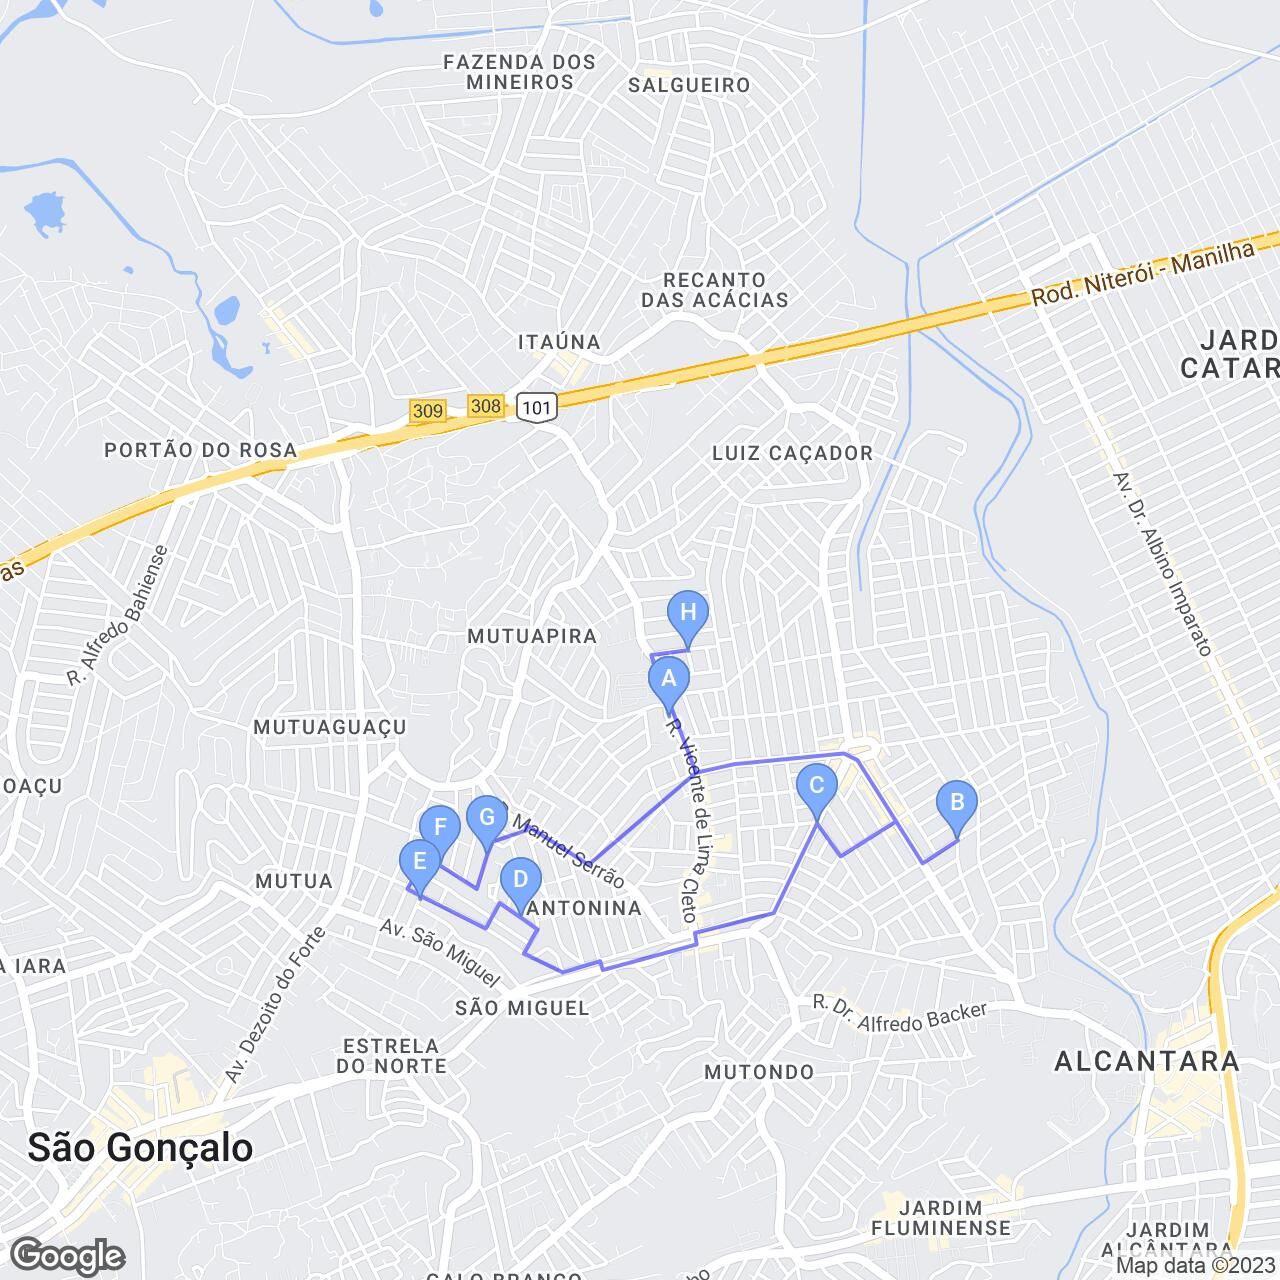

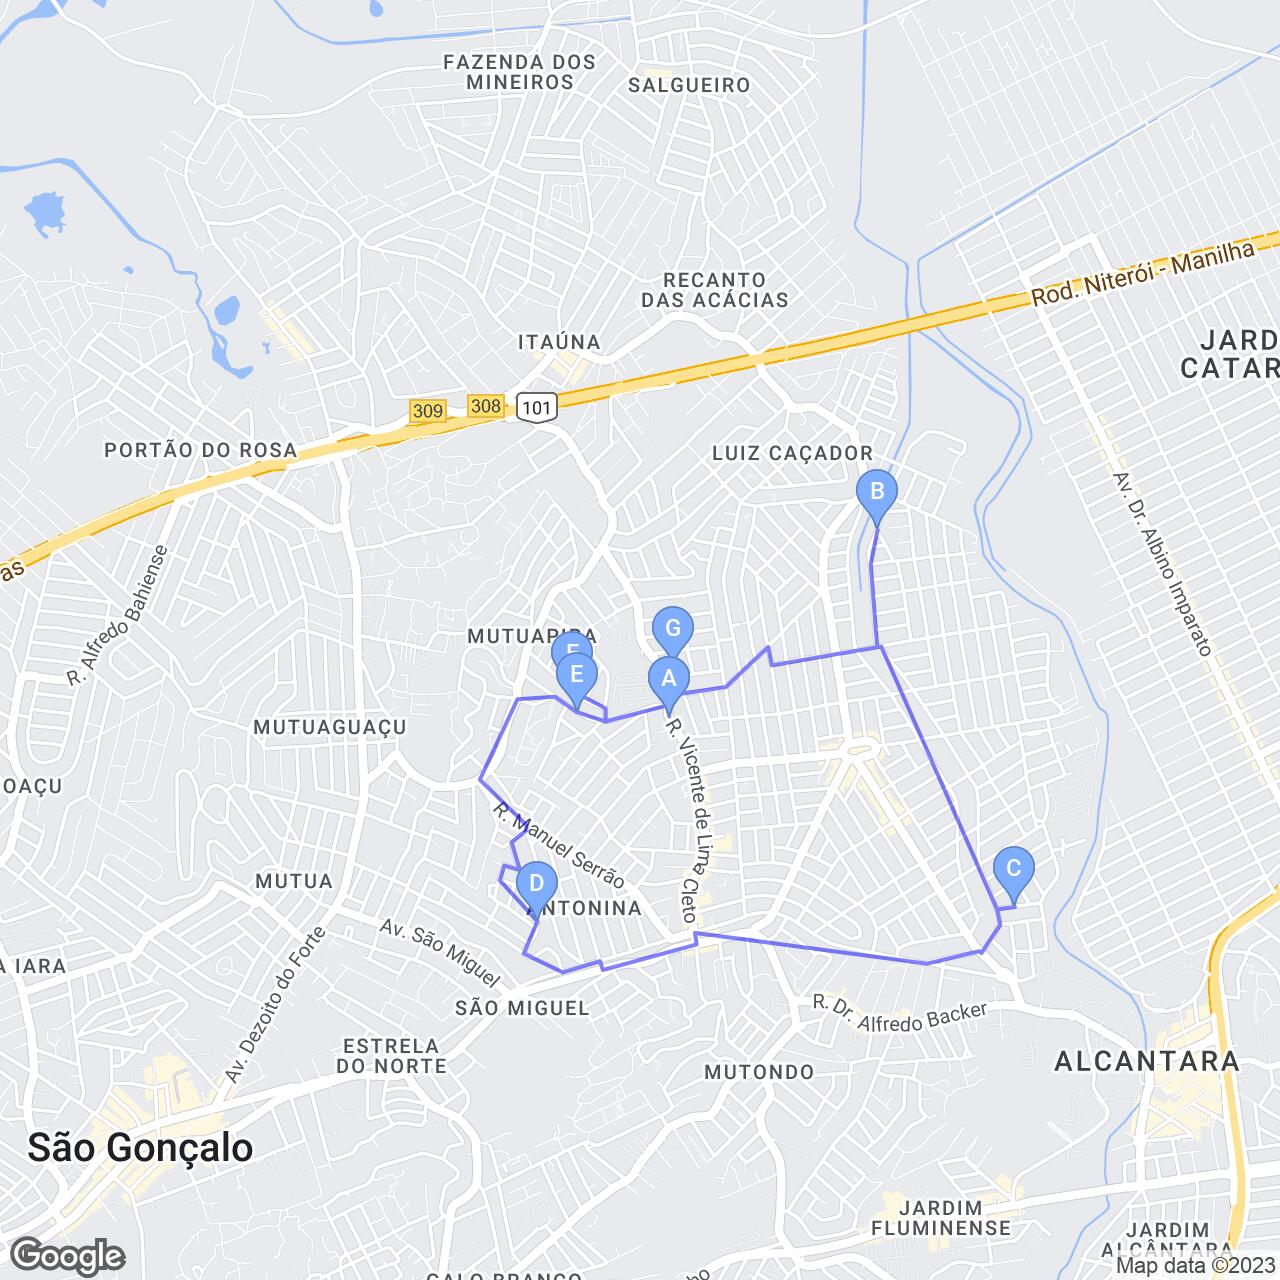

In [43]:
for image_count in range(1, number_of_routes + 1):
    with open(f'images/n{number_of_routes}_route_{image_count}.jpg', "rb") as file:
        image = Image(file.read(), width=600)
        display(image)